In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotlib as plib

from scipy.stats import gaussian_kde

## Load and filter data

In [2]:
mergeFn = '../../scripts/merged_features/Mammals.Homo_sapiens.with_reptime.features.txt.gz'
mergeDat = pd.read_csv(mergeFn, sep='\t')

In [3]:
# Prepare plot data
rtcol = 'reptiming'

keepCols = ['size', rtcol, 'Homo_sapiens-gc', 'chrom']
pltDat = mergeDat[keepCols].copy()
pltDat.dropna(how='any', inplace=True)
pltDat.rename(columns={'Homo_sapiens-gc':'gc'}, inplace=True)

# Remove small windows
pltDat = pltDat.loc[pltDat['size'] >= 1e4,]

# Remove non autosomal windows
pltDat = pltDat.loc[pltDat['chrom'] != 'chrX',]
pltDat = pltDat.loc[pltDat['chrom'] != 'chrY',]

print('{} windows remaining after filtering'.format(pltDat.shape[0]))

2376 windows remaining after filtering


## Run regression

In [4]:
x = pltDat['gc']
xmin = x.min()
xmax = x.max()

y = pltDat[rtcol]

# Density for coloring
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

x = sm.add_constant(x)
lm = sm.OLS(y, x)
lmFit = lm.fit()

ci = plib.get_CI(lmFit, x, y, bootstrap=True)

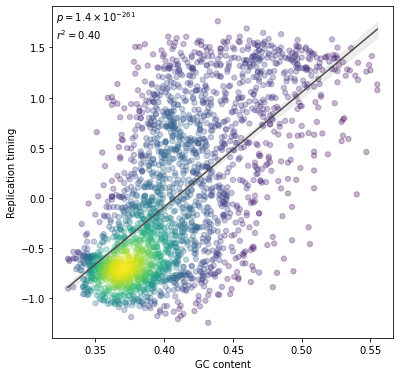

In [5]:
fig = plt.figure(figsize=(6.1, 6.1))
p = fig.add_subplot()

c = '#4d4d4d'

# Plot unity line
# p.axline((0,0), slope=1, c='#BBBBBB', ls='--', alpha=0.7)

# Plot regression line
plib.plot_line(lmFit.params['const'], lmFit.params['gc'], 
           xmin = xmin, xmax = xmax, c = c, ax = p)

p.fill_between(x=ci['xPred'][:,1], y1=ci['ci'][:,0], y2=ci['ci'][:,1], color='#DDDDDD', alpha=0.5)

# Plot scatter
p.scatter('gc', rtcol, data=pltDat, c=z, s=28, alpha=0.3)

lab = plib.make_pgls_legend(lam=None, pval=lmFit.pvalues['gc'], r2=lmFit.rsquared)
p.annotate(lab, xy=(0.01, 0.99), xycoords='axes fraction', verticalalignment='top')

p.set_xlabel('GC content')
p.set_ylabel('Replication timing')

# plim = (0.2, 0.7)

# p.set_xlim(0.2, 0.8)
# p.set_ylim(plim[0], plim[1])

plt.show(fig)
fig.savefig('../pdfs/Figure_SX_reptiming_vs_gc.pdf')

In [6]:
lmFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reptiming   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     1552.
Date:                Wed, 10 Nov 2021   Prob (F-statistic):          1.39e-261
Time:                        13:20:31   Log-Likelihood:                -2178.2
No. Observations:                2376   AIC:                             4360.
Df Residuals:                    2374   BIC:                             4372.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6663      0.119    -39.163      0.000      -4.900      -4.433
gc            11.4384      0.290     39.390      0.000      10.869      12.008
==============================================================================
Omnibus:                       47.989   Durbin-Watson:                   1.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.737
Skew:                           0.342   Prob(JB):                     1.58e-11
Kurtosis:                       2.817   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""